In [1]:
import sys
import os
workPath = os.path.abspath('..')
if not workPath in sys.path:
    sys.path.append(workPath)

In [2]:
from timeit import timeit
import numpy as np
from scipy import stats
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn import linear_model
import numpy as np
def regress(dataFrame, xs, y, keytuple = None, rounding = 2, intercept = True):
    lmOut = []
    lm = linear_model.LinearRegression(fit_intercept = True)
    if type(xs) == str:
        xs = [xs,]
    if not keytuple is None:
        key, keyval = keytuple
        dataFrame = dataFrame.loc[dataFrame[key] == keyval]
    dataXs = list(zip(*[dataFrame[x] for x in xs]))
    dataY = dataFrame[y]
    lm.fit(dataXs, dataY)
    lmOut = [np.round(item, rounding) for item in (lm.coef_, lm.intercept_, lm.score(dataXs, dataY))]
    lmOut[0] = list(lmOut[0])
    header = y + " vs " + str(xs) + '; coef, intercept, score:'
    return header, lmOut
def regress_series(dataFrame, xs, y, key, rounding = 2, intercept = True):
    outList = []
    header = ''
    for keyval in sorted(set(dataFrame[key])):
        header, datarow = regress(
            dataFrame,
            xs,
            y,
            keytuple = (key, keyval),
            rounding = rounding,
            intercept = intercept
            )
        outList.append((round(keyval, rounding), datarow))
    header = key + "; " + header
    return header, outList

In [4]:
from everest import window
from everest import _specialnames
Fetch = window.Fetch
Reader = window.Reader

In [5]:
projName = 'arrbench32'
outputPath = os.path.join(*['..', 'out', 'analysis', projName])
filePath = os.path.join(outputPath, projName + '.h5')

In [6]:
myreader = Reader(filePath)

In [7]:
filterScope = myreader[Fetch('Nu') > 0.]
attrDict = myreader.view_attrs(filterScope)

In [8]:
np.round(np.log10(sorted((attrDict['Ra'].keys()))), 1)

array([3., 4., 5., 6., 7.])

In [9]:
np.round(np.log10(sorted((attrDict['eta0'].keys()))), 1)

array([1., 2., 3., 4., 5.])

In [10]:
sorted((attrDict['f'].keys()))

[0.1, 0.3, 0.5, 0.7, 0.9]

In [11]:
fs = sorted(attrDict['f'].keys())[1:]
Ras = sorted(attrDict['Ra'].keys())[:-1]
eta0s = sorted(attrDict['eta0'].keys())

allData = []

for f in fs:
    fScope = attrDict['f'][f]
    for Ra in Ras:
        RaScope = attrDict['Ra'][Ra]
        for eta0 in eta0s:
            etaScope = attrDict['eta0'][eta0]
            thisScope = fScope * RaScope * etaScope
            if len(thisScope):
                Nus, modeltimes = myreader.pull(thisScope, ('Nu', 'modeltime'))
                recentNus, recentModeltimes = Nus[-100:], modeltimes[-100:]
                intervals = np.diff(recentModeltimes)
                NuAv = np.average(recentNus[1:], weights = intervals)
                allDataRow = (f, Ra, eta0, NuAv)
                allData.append(allDataRow)

allData = [row for row in allData if row[-1] < 10]

allData = np.array(allData)
fs, Ras, eta0s, NuAvs = allData.T

In [12]:
allDataFrame = pd.DataFrame(allData, columns = ['fs', 'Ras', 'eta0s', 'NuAvs'])
allDataFrame['Raf2'] = allDataFrame['Ras'] * allDataFrame['fs'] ** 2
allDataFrame['logNuAvs'] = np.log(allDataFrame['NuAvs'])
allDataFrame['logRaf2'] = np.log(allDataFrame['Raf2'])
allDataFrame['logEta0s'] = np.log(allDataFrame['eta0s'])
allDataFrame['log10NuAvs'] = np.log10(allDataFrame['NuAvs'])
allDataFrame['log10Raf2'] = np.log10(allDataFrame['Raf2'])
allDataFrame['log10Eta0s'] = np.log10(allDataFrame['eta0s'])

In [13]:
allDataFrame

,fs,Ras,eta0s,NuAvs,Raf2,logNuAvs,logRaf2,logEta0s,log10NuAvs,log10Raf2,log10Eta0s
0,0.3,1000.0,10.0,1.023945,90.0,0.023663,4.499810,2.302585,0.010277,1.954243,1.0
1,0.3,1000.0,100.0,1.024109,90.0,0.023823,4.499810,4.605170,0.010346,1.954243,2.0
2,0.3,1000.0,1000.0,1.024107,90.0,0.023821,4.499810,6.907755,0.010346,1.954243,3.0
3,0.3,1000.0,10000.0,1.024098,90.0,0.023813,4.499810,9.210340,0.010342,1.954243,4.0
4,0.3,1000.0,100000.0,1.024094,90.0,0.023808,4.499810,11.512925,0.010340,1.954243,5.0
...,...,...,...,...,...,...,...,...,...,...,...
72,0.9,100000.0,100000.0,2.164227,81000.0,0.772063,11.302204,11.512925,0.335303,4.908485,5.0
73,0.9,1000000.0,100.0,8.397363,810000.0,2.127918,13.604790,4.605170,0.924143,5.908485,2.0
74,0.9,1000000.0,1000.0,4.550420,810000.0,1.515220,13.604790,6.907755,0.658051,5.908485,3.0
75,0.9,1000000.0,10000.0,2.856397,810000.0,1.049561,13.604790,9.210340,0.455819,5.908485,4.0


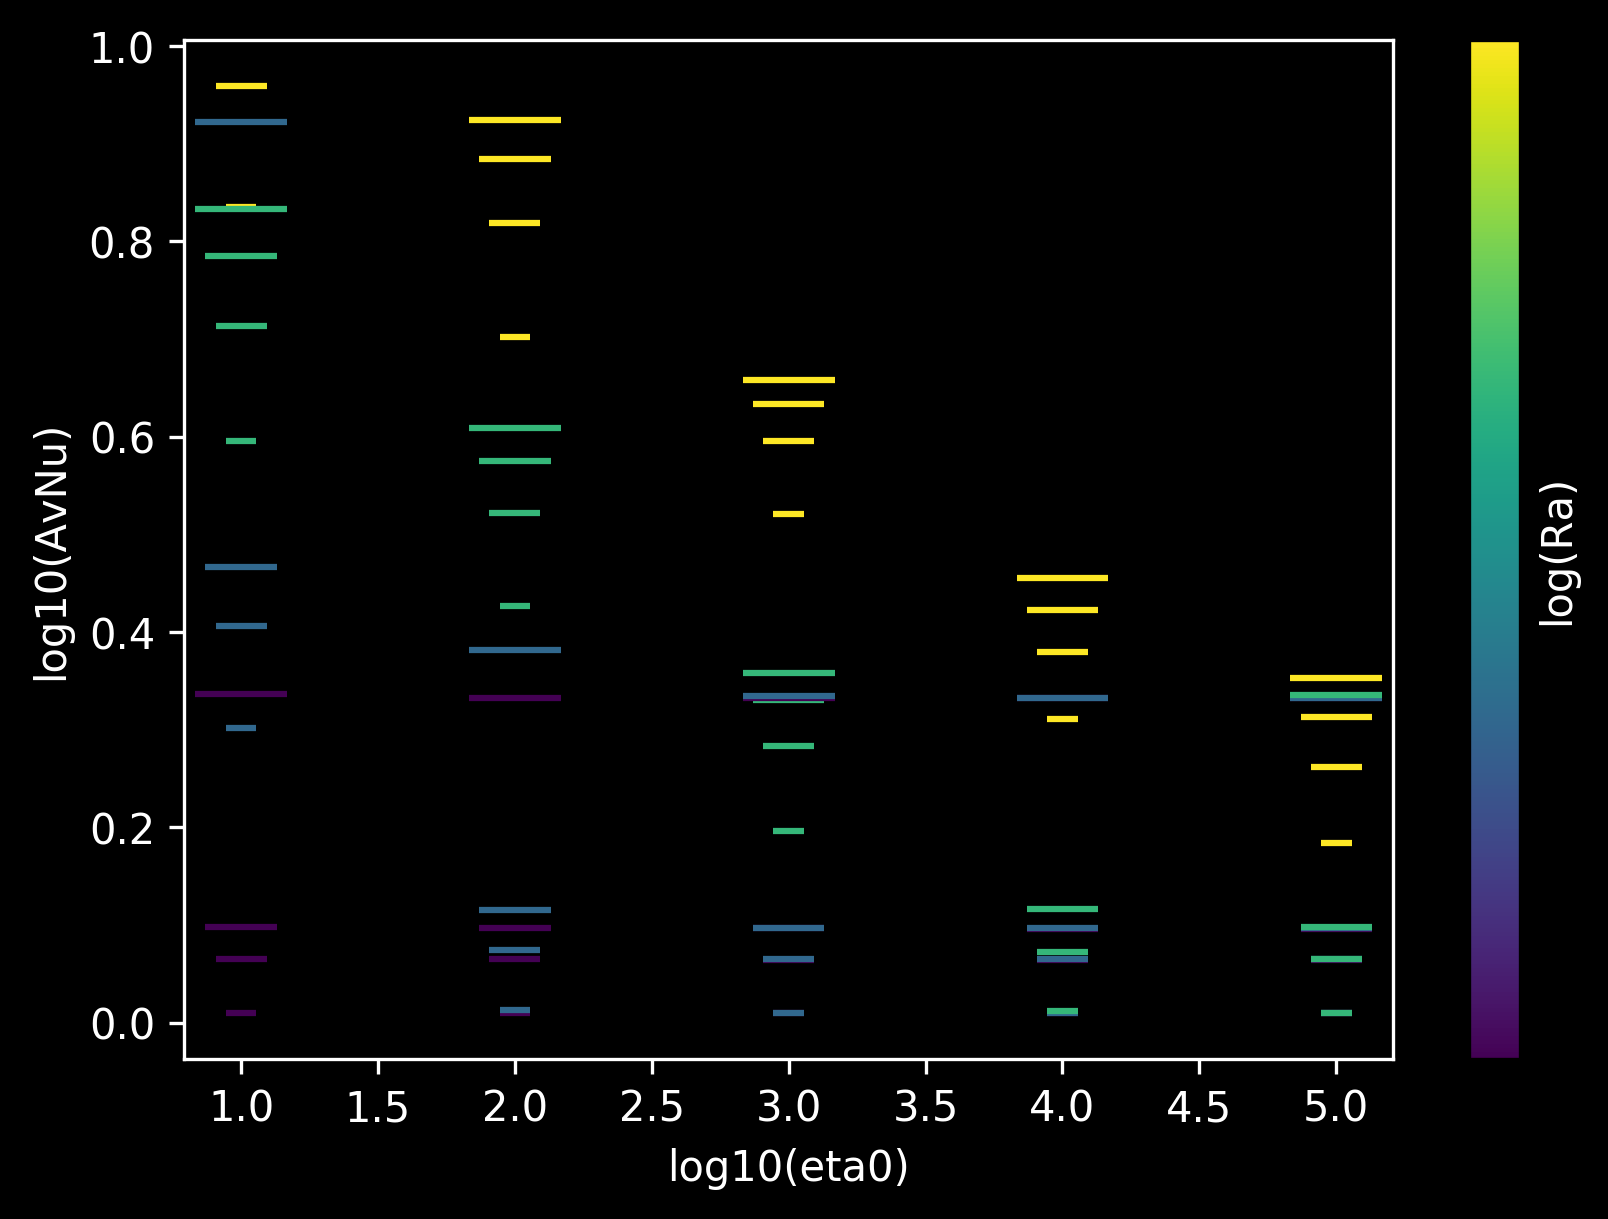

In [14]:
subFrame = allDataFrame

mpl.rcParams.update({
    'text.color': "white",
    'axes.labelcolor': "white"
    })

widthInches = 10
heightInches = 10

fig = plt.figure(facecolor = 'black', edgecolor = 'black', figsize = (6.5, 4.5), dpi = 300)
fig.add_axes()
ax = fig.add_subplot(111)
ax.set_facecolor('black')
# ax.grid(color = 'grey', linestyle = '-', linewidth = 2)
ax.tick_params(color = 'white', labelcolor = 'white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')

ax.set_xlabel('log10(eta0)')
ax.set_ylabel('log10(AvNu)')
# ax.set_xlim((0, 16))
# ax.set_ylim((0, 3))

logRas = np.log10(Ras)

cmap = plt.get_cmap('viridis')
norm = mpl.colors.Normalize(
    vmin = np.min(logRas),
    vmax = np.max(logRas)
    )

scatter = ax.scatter(
    np.log10(eta0s),
    np.log10(NuAvs),
    c = norm(logRas),
    cmap = cmap,
    s = 600. * fs ** 2,
    edgecolor = 'white',
    alpha = 1.,
    marker = '_'
    )

cbar = plt.colorbar(scatter)
cbarticks = cbar.set_ticks(logRas)
cbar.ax.yaxis.set_tick_params(color = 'white')
cbar.set_label('log(Ra)', color = 'white')
ignoreme = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color = 'white')

# for val in sorted(set(subFrame['logRaf2'])):
#     subsubFrame = subFrame.loc[subFrame['logRaf2'] == val]
#     xs = subsubFrame['log10Eta0s']
#     ys = subsubFrame['log10NuAvs']
#     zs = np.polyfit(xs, ys, 1)
#     p = np.poly1d(zs)
#     if regressionDict[round(val, 2)][2] > 0.9:
#         plt.plot(xs, p(xs), "w", alpha = 0.5)

In [15]:
eta0_regression_header, eta0_regression = regress_series(allDataFrame, 'logEta0s', 'logNuAvs', key = 'logRaf2')
eta0_regression_dict = dict(eta0_regression)
eta0_regression_filtered = [row for row in eta0_regression if row[1][2] > 0.9]
eta0_regression_filtered_dict = dict(eta0_regression_filtered)

In [16]:
eta0_regression_filtered_dict

{9.1: [[-0.16], 1.67, 0.94],
 10.13: [[-0.17], 1.97, 0.95],
 10.8: [[-0.18], 2.14, 0.95],
 11.41: [[-0.17], 2.35, 0.99],
 12.43: [[-0.18], 2.65, 0.99],
 13.1: [[-0.19], 2.85, 0.97],
 13.6: [[-0.19], 2.92, 0.96]}

In [17]:
averageGoodSlope = np.average([row[1][0][0] for row in eta0_regression_filtered])
averageGoodSlopeScore = np.average([row[1][2] for row in eta0_regression_filtered])
(averageGoodSlope, averageGoodSlopeScore)

(-0.17714285714285713, 0.9642857142857143)

Text(0.5, 1.0, '(average slope, score > 0.9 = -0.18)')

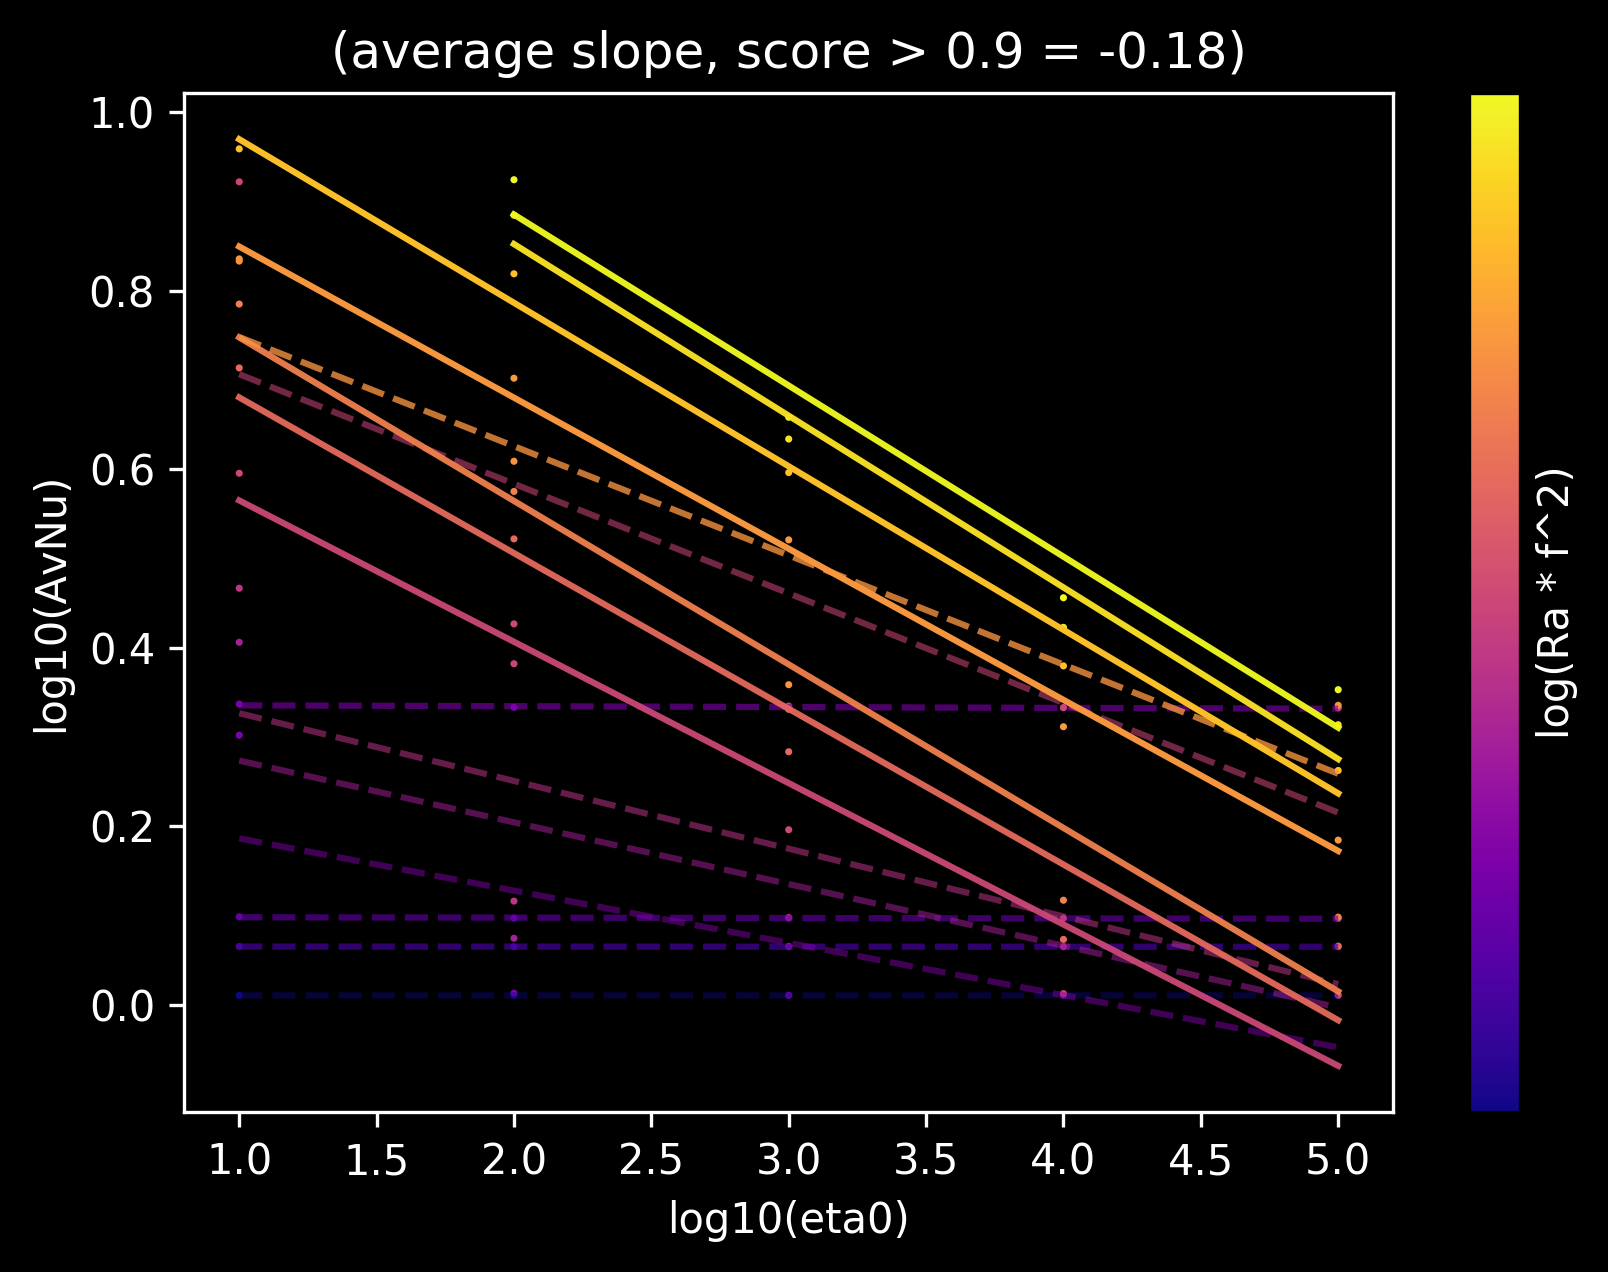

In [18]:
subFrame = allDataFrame

mpl.rcParams.update({
    'text.color': "white",
    'axes.labelcolor': "white"
    })

widthInches = 10
heightInches = 10

fig = plt.figure(facecolor = 'black', edgecolor = 'black', figsize = (6.5, 4.5), dpi = 300)
fig.add_axes()
ax = fig.add_subplot(111)
ax.set_facecolor('black')
# ax.grid(color = 'grey', linestyle = '-', linewidth = 2)
ax.tick_params(color = 'white', labelcolor = 'white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')

ax.set_xlabel('log10(eta0)')
ax.set_ylabel('log10(AvNu)')
# ax.set_xlim((0, 16))
# ax.set_ylim((0, 3))

cSet = subFrame['logRaf2']

cmap = plt.get_cmap('plasma')
norm = mpl.colors.Normalize(
    vmin = np.min(cSet),
    vmax = np.max(cSet)
    )

scatter = ax.scatter(
    subFrame['log10Eta0s'],
    subFrame['log10NuAvs'],
    c = norm(np.array(cSet)),
    cmap = cmap,
    s = 0.5,
#     edgecolor = 'white',
#     alpha = 0.1,
    )

cbar = plt.colorbar(scatter, alpha = 1.)
cbarticks = cbar.set_ticks(logRas)
cbar.ax.yaxis.set_tick_params(color = 'white')
cbar.set_label('log(Ra * f^2)', color = 'white')
ignoreme = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color = 'white')

for val in sorted(set(subFrame['logRaf2'])):
    subsubFrame = subFrame.loc[subFrame['logRaf2'] == val]
    xs = subsubFrame['log10Eta0s']
    ys = subsubFrame['log10NuAvs']
    zs = np.polyfit(xs, ys, 1)
    p = np.poly1d(zs)
    score =  eta0_regression_dict[round(val, 2)][2]
    if score > 0.9:
        linestyle = '-'
    else:
        linestyle = '--'
    alpha = score
    plt.plot(
        xs,
        p(xs),
        color = cmap(norm(val)),
        alpha = alpha,
        linestyle = linestyle
        )

plt.title("(average slope, score > 0.9 = %.2f)"%averageGoodSlope)

In [31]:
eta0_regression_filtered

[(9.1, [[-0.16], 1.67, 0.94]),
 (10.13, [[-0.17], 1.97, 0.95]),
 (10.8, [[-0.18], 2.14, 0.95]),
 (11.41, [[-0.17], 2.35, 0.99]),
 (12.43, [[-0.18], 2.65, 0.99]),
 (13.1, [[-0.19], 2.85, 0.97]),
 (13.6, [[-0.19], 2.92, 0.96])]

In [33]:
logRaf2s = [row[0] for row in eta0_regression_filtered]
intercepts = [row[1][1] for row in eta0_regression_filtered]
slope, intercept, rvalue, pvalue, stderr = stats.linregress(logRaf2s, intercepts)
print("Slope: ", round(slope, 2), ", score: ", round(rvalue, 2), ", intercept: ", round(intercept, 2))

Slope:  0.29 , score:  1.0 , intercept:  -0.93


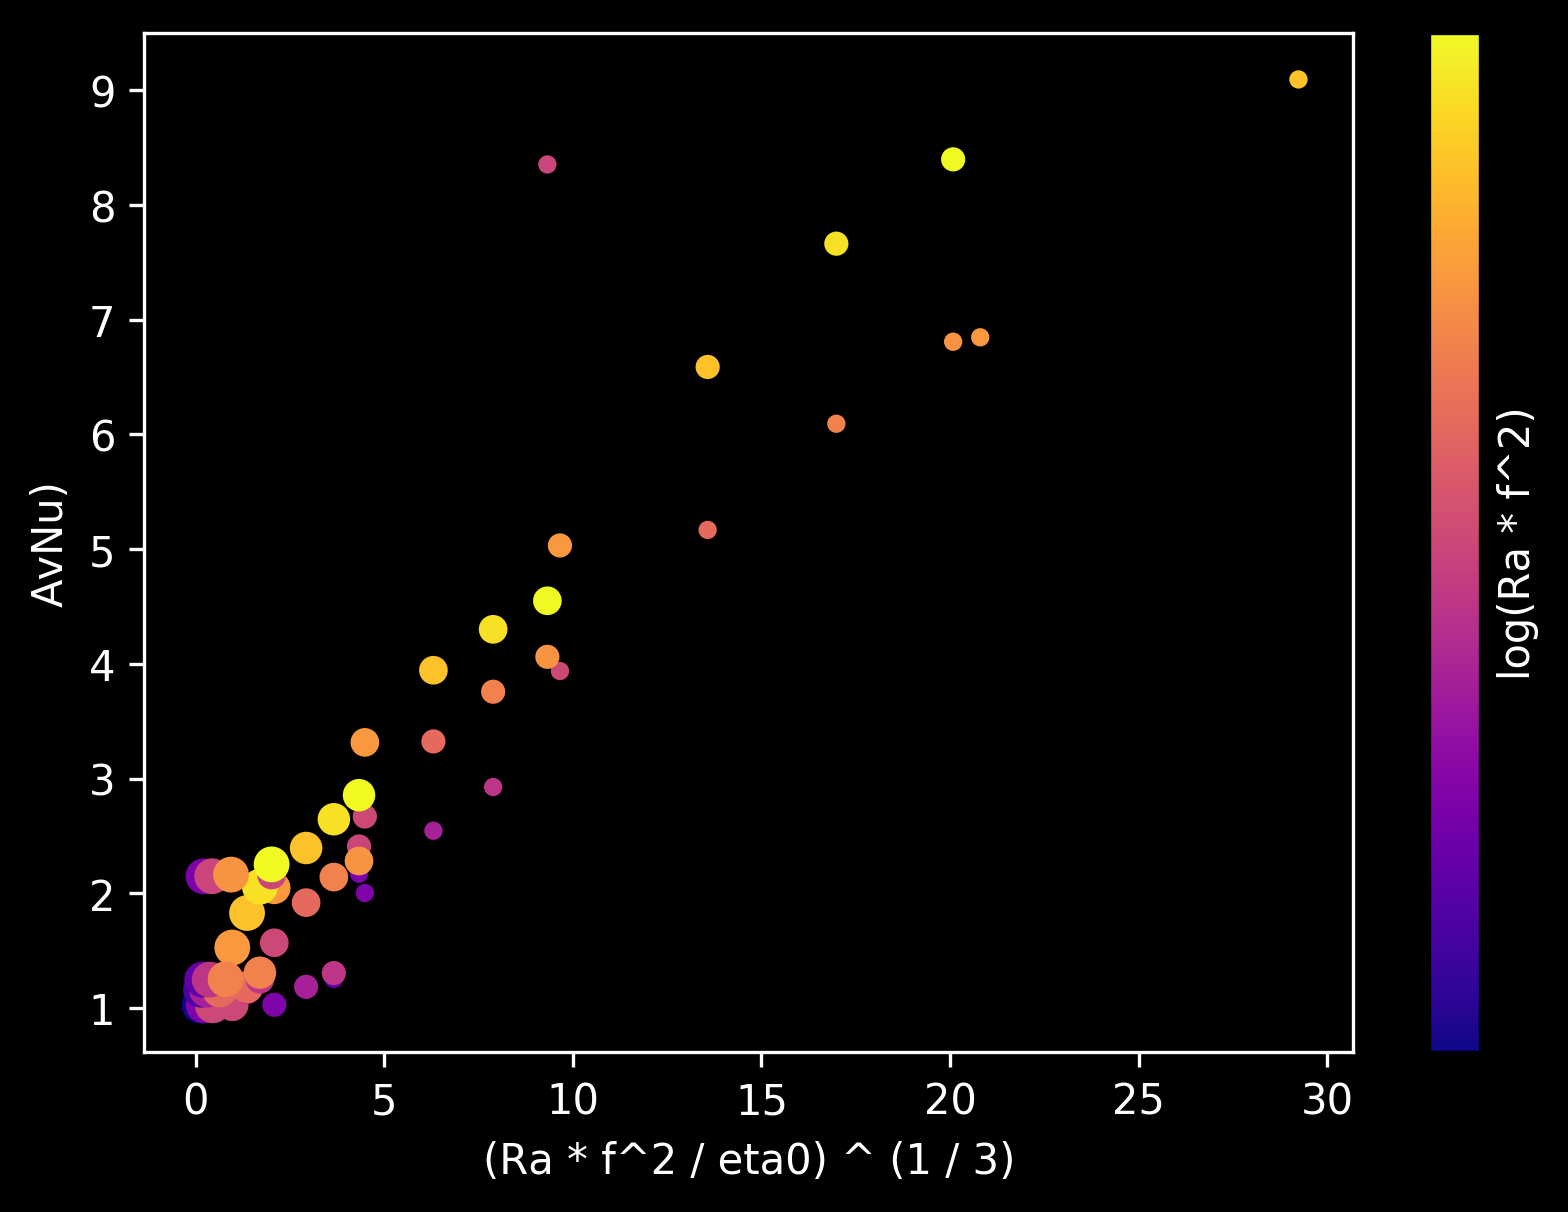

In [61]:
subFrame = allDataFrame

mpl.rcParams.update({
    'text.color': "white",
    'axes.labelcolor': "white"
    })

fig = plt.figure(facecolor = 'black', edgecolor = 'black', figsize = (6.5, 4.5), dpi = 300)
fig.add_axes()
ax = fig.add_subplot(111)
ax.set_facecolor('black')
# ax.grid(color = 'grey', linestyle = '-', linewidth = 2)
ax.tick_params(color = 'white', labelcolor = 'white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')

ax.set_xlabel('(Ra * f^2 / eta0) ^ (1 / 3)')
ax.set_ylabel('AvNu)')
# ax.set_xlim((0, 16))
# ax.set_ylim((0, 3))

cSet = subFrame['logRaf2']
cmap = plt.get_cmap('plasma')
norm = mpl.colors.Normalize(
    vmin = np.min(cSet),
    vmax = np.max(cSet)
    )

scatter = ax.scatter(
    (subFrame['Raf2'] / subFrame['eta0s']) ** (1. / 3.),
    subFrame['NuAvs'],
    c = norm(np.array(cSet)),
    cmap = cmap,
    s = 5. * subFrame['logEta0s'],
#     edgecolor = 'white',
#     alpha = 0.1,
    )

cbar = plt.colorbar(scatter)
cbarticks = cbar.set_ticks(logRas)
cbar.ax.yaxis.set_tick_params(color = 'white')
cbar.set_label('log(Ra * f^2)', color = 'white')
ignoreme = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color = 'white')

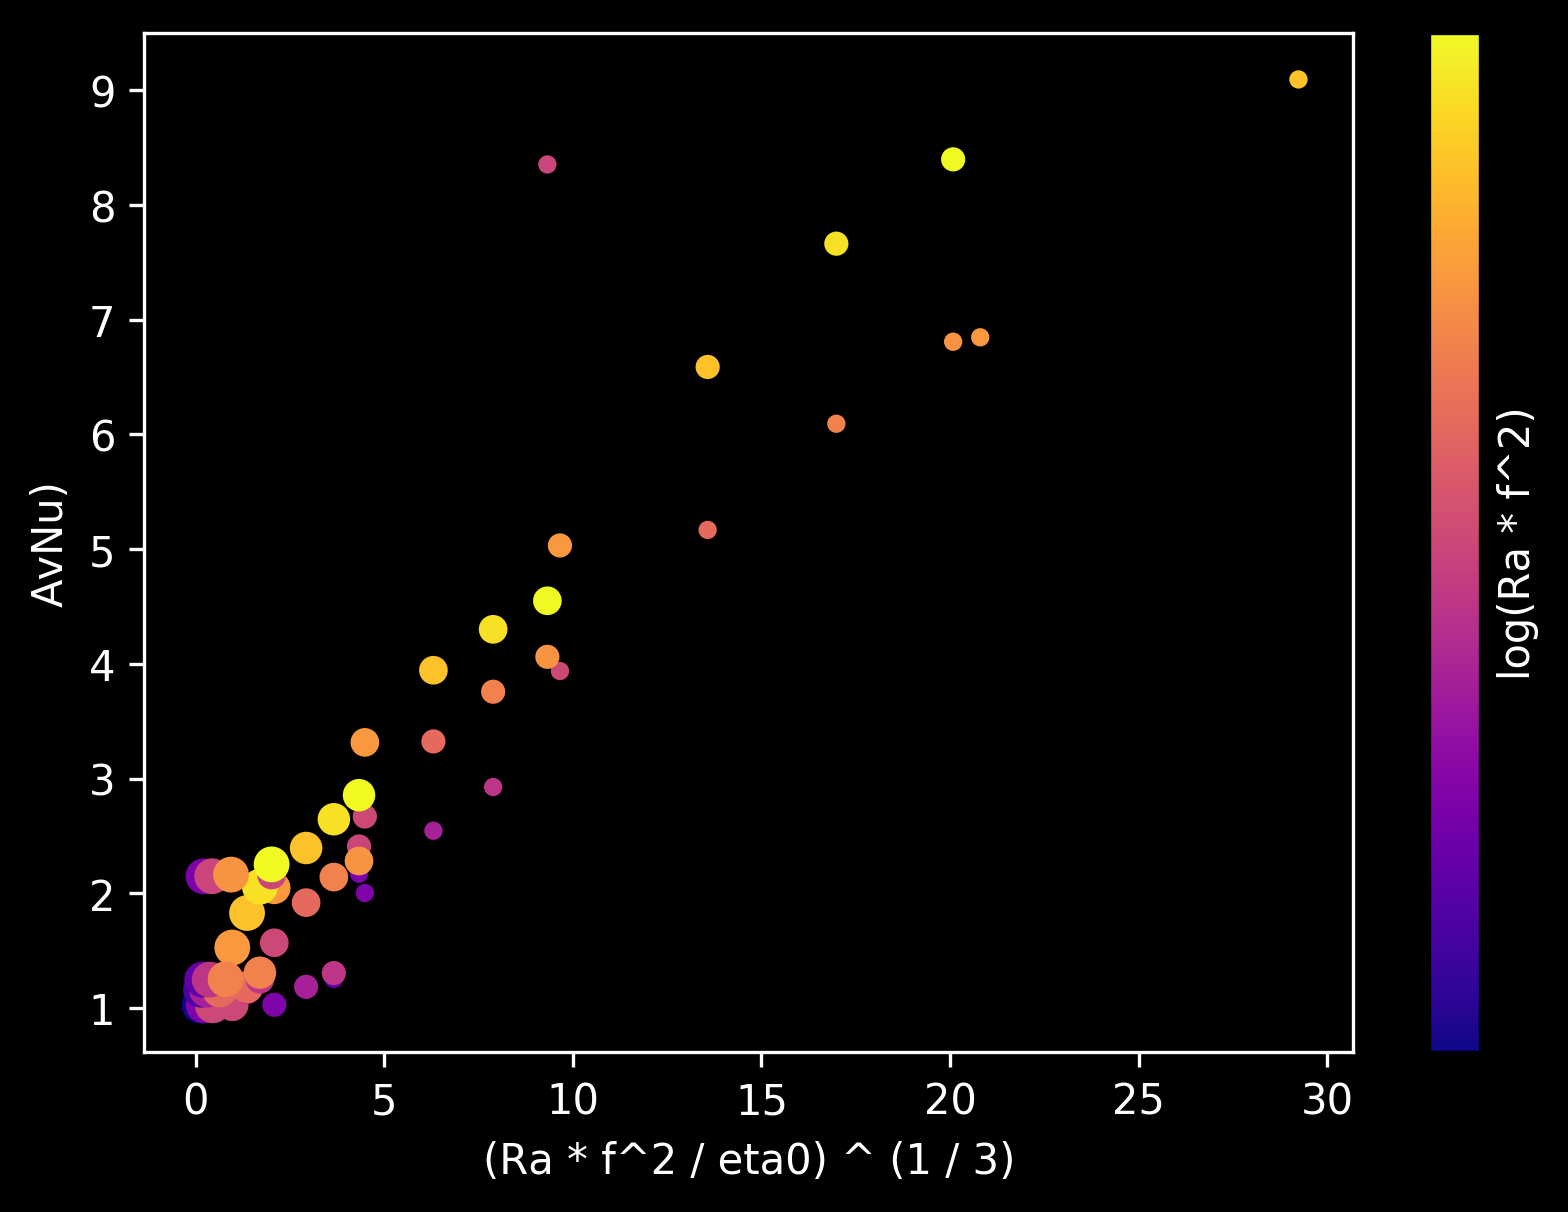

In [36]:
subFrame = allDataFrame

mpl.rcParams.update({
    'text.color': "white",
    'axes.labelcolor': "white"
    })

fig = plt.figure(facecolor = 'black', edgecolor = 'black', figsize = (6.5, 4.5), dpi = 300)
fig.add_axes()
ax = fig.add_subplot(111)
ax.set_facecolor('black')
# ax.grid(color = 'grey', linestyle = '-', linewidth = 2)
ax.tick_params(color = 'white', labelcolor = 'white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')

ax.set_xlabel('(Ra * f^2 / eta0) ^ (1 / 3)')
ax.set_ylabel('AvNu)')
# ax.set_xlim((0, 16))
# ax.set_ylim((0, 3))

cSet = subFrame['logRaf2']
cmap = plt.get_cmap('plasma')
norm = mpl.colors.Normalize(
    vmin = np.min(cSet),
    vmax = np.max(cSet)
    )

scatter = ax.scatter(
    (subFrame['Raf2'] / subFrame['eta0s']) ** (1. / 3.),
    subFrame['NuAvs'],
    c = norm(np.array(cSet)),
    cmap = cmap,
    s = 5. * subFrame['logEta0s'],
#     edgecolor = 'white',
#     alpha = 0.1,
    )

cbar = plt.colorbar(scatter)
cbarticks = cbar.set_ticks(logRas)
cbar.ax.yaxis.set_tick_params(color = 'white')
cbar.set_label('log(Ra * f^2)', color = 'white')
ignoreme = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color = 'white')

In [59]:
allDataFrame['THEORETICALSCALING'] = (allDataFrame['Raf2'] / allDataFrame['eta0s']) ** (0.333)

In [60]:
regress(allDataFrame, 'THEORETICALSCALING', 'NuAvs')

("NuAvs vs ['THEORETICALSCALING']; coef, intercept, score:",
 [[0.32], 1.15, 0.86])

In [28]:
allDataFrame['Raf2/eta0'] = allDataFrame['Raf2'] / allDataFrame['eta0s']
allDataFrame['logRaf2/eta0'] = np.log(allDataFrame['Raf2/eta0'])
allDataFrame['Raf2/sqrteta0'] = allDataFrame['Raf2'] / np.sqrt(allDataFrame['eta0s'])
allDataFrame['logRaf2/sqrteta0'] = np.log(allDataFrame['Raf2/sqrteta0'])

In [29]:
regress_series(allDataFrame, 'logRaf2/eta0', 'logNuAvs', 'eta0s')

("eta0s; logNuAvs vs ['logRaf2/eta0']; coef, intercept, score:",
 [(10.0, [[0.29], -0.64, 0.89]),
  (100.0, [[0.25], -0.21, 0.89]),
  (1000.0, [[0.17], 0.28, 0.8]),
  (10000.0, [[0.09], 0.44, 0.5]),
  (100000.0, [[0.07], 0.53, 0.36])])

In [30]:
regress_series(allDataFrame, 'logRaf2/sqrteta0', 'logNuAvs', 'eta0s')

("eta0s; logNuAvs vs ['logRaf2/sqrteta0']; coef, intercept, score:",
 [(10.0, [[0.29], -0.98, 0.89]),
  (100.0, [[0.25], -0.79, 0.89]),
  (1000.0, [[0.17], -0.29, 0.8]),
  (10000.0, [[0.09], 0.01, 0.5]),
  (100000.0, [[0.07], 0.15, 0.36])])